### 로지스틱 회귀

In [ ]:
# 라이브러리 import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import rand, multivariate_normal

# 데이터 프레임 경고 없애기
pd.options.mode.chained_assignment = None

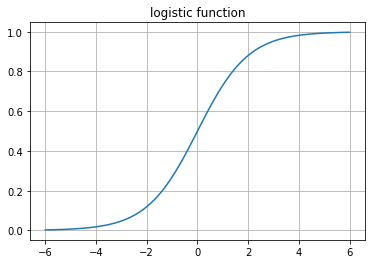

In [ ]:
# 로지스틱 함수 시각화
x = np.linspace(-6,6,101) 
y = 1.0/(1.0+np.exp(-x)) # 로지스틱 함수

fig, ax = plt.subplots()
ax.set_title("logistic function")
ax.grid(True)
ax.plot(x,y)
fig.show()

In [ ]:
# 데이터 셋({x_n, y_n, type_n}) 만드는 함수(prepare_dataset) 선언하기
# 개수가 N = N1+N2 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋
#
# parameters = {
#     "N1": t = 1인 데이터 개수,
#     "Mu1": t = 1인 데이터 중심 [x,y] 좌표,
#     "N2": t = 0인 데이터 개수},
#     "Mu2": t = 0인 데이터 중심 [x,y] 좌표,
# }

def prepare_dataset(parameters, variance):
    N1 = parameters["N1"] # t = 1인 데이터 개수
    Mu1 =  parameters["Mu1"] # t = 1인 데이터 중심 [x,y] 좌표
    N2 = parameters["N2"]  # t = 0인 데이터 개수
    Mu2 = parameters["Mu2"] # t = 0인 데이터 중심 (x,y) 좌표

    # 공분산 행렬 C = [[Var(X),Cov(X,Y)], [Cov(Y,X),Var(Y)]
    # Var(X): X축 분산, Var(Y): Y축 분산
    # Cov(X,Y) = 0, Cov(Y,X) = 0인 공분산. 두 변수 X, Y는 서로 독립적. 
    # 공분산이 0이고 X축, Y축 분산이 같음
    cov1 = np.array([[variance,0],[0,variance]])
    cov2 = np.array([[variance,0],[0,variance]])

    # t=+1인 데이터 생성
    df1 = pd.DataFrame(multivariate_normal(Mu1,cov1,N1),columns=['x','y'])
    df1['t'] = 1
    # t=-1인 데이터 생성
    df2 = pd.DataFrame(multivariate_normal(Mu2,cov2,N2),columns=['x','y'])
    df2['t'] = 0
    
    # 생성된 데이터 합치기
    df = pd.concat([df1,df2],ignore_index=True)

    # df에 index를 랜덤으로 섞기
    df = df.reindex(np.random.permutation(df.index))
    
    # df에 index를 처음부터 다시 라벨링하기 
    # drop = True는 새로운 index를 추가로 만들지 않게 하기 위해서
    df = df.reset_index(drop=True)
    
    return df

In [ ]:
# 퍼셉트론을 사용하여 파라미터를 계산하는 함수 (4장)
# 인풋: 트레이닝 셋, 이터레이션 횟수
# 아웃풋: results(w0, w1, w2, c, err_rate), paramhist

def calc_perceptron_parameters(training_set, iteration_num, bias = None):
    # w 초기값 설정하기
    w0 = w1 = w2 = 0.0

    # c는 bias항
    if bias is None:
        c = 0.5 * (training_set.x.mean() + training_set.y.mean())
    else:
        c = bias

    # 확률적 기울기 하강
    paramhist = pd.DataFrame([[w0,w1,w2]], columns=['w0','w1','w2']) # paramhist: parameter history
    for i in range(iteration_num):
        for _, point in training_set.iterrows():
            x, y, t = point.x, point.y, point.t
            
            # 5장 데이터 라벨: t = 1, t = 0
            # 4장 데이터 라벨: t = 1, t = -1
            # 따라서 t = t*2 - 1이라는 함수를 사용하여 1을 1로, 0을 -1로 변경 
            t = t*2-1
            
            # w_new = w_old + t_n * phi_n
            if t * (w0*c + w1*x + w2*y) <= 0: # 잘못 분류된 트레이팅 셋 데이터만 대상
                w0 += t * c 
                w1 += t * x
                w2 += t * y

        paramhist = paramhist.append(
                        pd.Series([w0,w1,w2], ['w0','w1','w2']),
                        ignore_index=True)
   
    # 잘못 분류된 데이터 비율(%) 계산하기
    # err: 잘못된 데이터 개수
    err_num = 0
    for _, point in training_set.iterrows():
        x, y, t = point.x, point.y, point.t
        t = t*2-1
        if t * (w0*c + w1*x + w2*y) <= 0:
            err_num += 1
    err_rate = err_num / len(training_set) * 100

    result = {
        "w0": w0,
        "w1": w1,
        "w2": w2,
        "err_rate": err_rate,
        "bias": c
    }

    return result, paramhist

In [ ]:
# 로지스틱 회귀분석을 사용하여 파라미터를 계산하는 함수
# 인풋: 트레이닝 셋, 이터레이션 횟수
# 아웃풋: 결과(w0, w1, w2, err_rate)

def calc_logistic_parameter(training_set, iteration_num):

    w_old = np.array([[0],[0.1],[0.1]]) # 초기 w_old 값 설정 
    phi = training_set[['x','y']]
    phi['bias'] = 1
    phi = phi[["bias","x","y"]] # phi의 열순서를 "bias", "x", "y"순으로 변경
    phi = phi.values # datafame phi를 ndarray로 변환
    t = training_set[['t']] # training_set의 "t"열을 t에 대입
    t = t.values # dataframe t를 ndarray로 변환

    for i in range(iteration_num):
        # IRLS법에 의한 파라미터의 수정
        # IRLS Iteratively Reweighted Least Squares
        # z 벡터 계산    
        z = np.array([])
        for line in phi:
            a = np.dot(w_old.T, line) # a = w.T • phi
            z = np.append(z, [1.0/(1.0+np.exp(-a))])  # z = logistic(a)

        # w_new = w_old - inv(phi.T•R•phi) • phi_T • (z - t)
        # tmp1 = inv(phi.T•R•phi)
        # tmp2 = phi_T • (z - t)
        # w_new = w_old - tmp1 • tmp2        
        R = np.diag(z*(1-z)) 
        z = z[np.newaxis,:].T # z는 (N,1) 행렬
        tmp1 = np.linalg.inv(np.dot(np.dot(phi.T, R),phi))
        tmp2 = np.dot(phi.T, (z-t))
        w_new = w_old - np.dot(tmp1, tmp2)

        # 파라미터의 변화가 0.1% 미만이 되면 종료
        if np.dot((w_new-w_old).T, (w_new-w_old)) < 0.001 * np.dot(w_old.T, w_old):
            w_old = w_new
            break
        w_old = w_new

    # 분류 오차 계산
    w0, w1, w2 = w_new[0], w_new[1], w_new[2]

    err = 0
    for _, point in training_set.iterrows():
        x, y, t = point.x, point.y, point.t
        t = t * 2 - 1
        if t * (w0 + w1*x + w2*y) < 0:
            err += 1
    err_rate = err * 100 / len(training_set)
    
    result = {
        "w0": w0,
        "w1": w1,
        "w2": w2,
        "err_rate": err_rate,
    }

    return result

In [ ]:
# 결과를 시각화 하는 함수들

#트레이닝 셋 시각화
def plot_training_data(training_set,ax):
    training_set1 = training_set[training_set['t']==1] # t=1인 트레이닝 셋
    training_set2 = training_set[training_set['t']==0] # t=0인 트레이닝 셋
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    ymin, ymax = training_set.y.min()-5, training_set.y.max()+10
    ax.set_xlim([xmin-1, xmax+1])
    ax.set_ylim([ymin-1, ymax+1])
    ax.scatter(training_set1.x, training_set1.y, marker='o')
    ax.scatter(training_set2.x, training_set2.y, marker='x')

# 퍼셉트론을 사용한 결과 시각화
def plot_peceptron_graph(training_set, parameters, ax): 
    w0 = parameters["w0"]
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    bias = parameters["bias"]
    err_rate = parameters["err_rate"]
   
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - bias * w0 / w2
    label = "ERR %.2f%%" % err_rate
    ax.plot(linex, liney, label=label, color='red', linestyle='--')
    ax.legend(loc=1)

# 로지스틱 회귀분석을 사용한 결과 시각화
def plot_logistic_regression_graph(training_set,parameters, ax):
    w0 = parameters["w0"]
    w1 = parameters["w1"]
    w2 = parameters["w2"]
    err_rate = parameters["err_rate"]
    
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - w0 / w2
    label = "ERR %.2f%%" % err_rate
    ax.plot(linex,liney ,label=label, color='blue')
    ax.legend(loc=1)

In [ ]:
# 파라미터 
# 개수가 N = N1+N2 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋
initial_parameters = {
    "N1": 30, # t = 1인 데이터 개수
    "Mu1": [7,7], # t = 1인 데이터 중심 [x,y] 좌표
    "N2": 30, # t = 0인 데이터 개수
    "Mu2": [-3,-3] # t = 0인 데이터 중심 (x,y) 좌표
}
variance_list = [5,10,30,50] # 양 클래스 공통의 분산(4종류의 분산으로 계산 실시)
iteration_num = 50

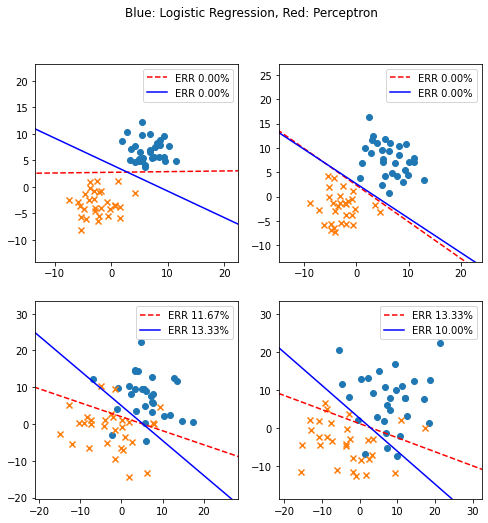

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
fig.suptitle('Blue: Logistic Regression, Red: Perceptron')
for c, variance in enumerate(variance_list):
    # 시각화 할 그래프 그리드 위치 설정
    ax = axs[int(c/2),c%2]

    # 트레이닝 셋 생성
    training_set = prepare_dataset(initial_parameters, variance)

    # 트레이닝 셋 시각화
    plot_training_data(training_set,ax)
    # 퍼셉트론을 사용하여 계산 및 시각화
    perceptron_parameters, _ = calc_perceptron_parameters(training_set,iteration_num)
    plot_peceptron_graph(training_set, perceptron_parameters, ax)

    # 로지스틱 회귀 분석을 사용하여 계산 및 시각화
    logistic_parameters = calc_logistic_parameter(training_set, iteration_num)
    plot_logistic_regression_graph(training_set,logistic_parameters, ax)

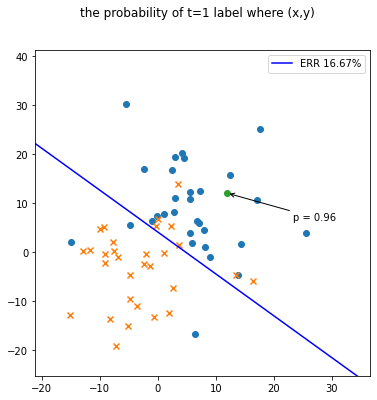

In [ ]:
# x,y위치 값이 t=1라벨로 분류될 확률 계산하기
variance = 60
x,y = (12,12)


fig,ax = plt.subplots(1,1,figsize=(6,6))
fig.suptitle("the probability of t=1 label where (x,y)")

# 시각화 할 그래프 그리드 위치 설정
# 트레이닝 셋 생성
training_set = prepare_dataset(initial_parameters, variance)

# 트레이닝 셋 시각화
plot_training_data(training_set,ax)

# 로지스틱 회귀 분석을 사용하여 계산 및 시각화
logistic_parameters = calc_logistic_parameter(training_set, iteration_num)
plot_logistic_regression_graph(training_set,logistic_parameters, ax)

ax.scatter(x,y)

w = [logistic_parameters["w0"],logistic_parameters["w1"],
     logistic_parameters["w2"]]

a = np.dot(np.array([1, x, y]), w)
probability = 1.0/(1.0+np.exp(-a))
ax.annotate('p = %.2f'%(probability), xy=(x, y),  xycoords='data',
            xytext=(0.9, 0.5), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->'),
            horizontalalignment='right', verticalalignment='top',
            )

fig.show()

### ROC 곡선

In [ ]:
# ROC 계산 
# ROC: Receiver Operating Caracteristic
def calc_roc(training_set, parameter):
    # 각 데이터 확률 계산
    w =  [parameter["w0"], parameter["w1"], parameter["w2"]]
    training_set['probability'] = 0.0
    err = 0
    for index, line in training_set.iterrows():
        a = np.dot(np.array([1, line.x, line.y]), w)
        p = 1.0/(1.0+np.exp(-a))
        training_set.loc[index, 'probability'] = p
        if (p-0.5)*(line.t*2-1) < 0:
            err += 1
    err_rate = err * 100 / len(training_set)
    result = training_set.sort_values(by=['probability'], ascending=[False]).reset_index(drop = True)

    # 진양성률 및 위양성률 계산
    # n(데이터 인덱스): [0,1, ... n ... ,N-1]
    # t(데이터 속성): [t_1, t_2, ... t_n ... , t_N-1]
    # 확률: [probability_1, probabilty_2, ... probability_n  ... , probability_N]
    positives = len(result[result['t']==1]) # 양성 데이터 개수
    negatives = len(result[result['t']==0]) # 음성 데이터 개수
    tp = [0.0] * len(result) 
    fp = [0.0] * len(result) 

    # index가 n일 때  확률이 probabilty_n보다 큰지가 판단 기준
    # 데이터가 정렬되어 있기 때문에, n보다 낮은 index에서는 항상 p값이 더 높음
    for n, line in result.iterrows():
        for c in np.arange(0,n):
            if result.t[c] == 1:
                tp[n] += 1
            else:
                fp[n] += 1
        
    tp_rate = np.array(tp) / positives # tp_rate(진양성률): true positive
    fp_rate = np.array(fp) / negatives # fp_rate(위양성률): false positive
    result = {
        "tp_rate": tp_rate,
        "fp_rate": fp_rate
    }

    return result

In [ ]:
def plot_training_set(training_set, parameter, ax):
    w0 = parameter["w0"]
    w1 = parameter["w1"]
    w2 = parameter["w2"]
    err_rate = parameter["err_rate"]

    training_set1 = training_set[training_set['t']==1]
    training_set2 = training_set[training_set['t']==0]
    xmin, xmax = training_set.x.min()-5, training_set.x.max()+10
    ymin, ymax = training_set.y.min()-5, training_set.y.max()+10
    ax.set_ylim([ymin-1, ymax+1])
    ax.set_xlim([xmin-1, xmax+1])

    # 분류 데이터 표시
    ax.scatter(training_set1.x, training_set1.y, marker='o')
    ax.scatter(training_set2.x, training_set2.y, marker='x')

    # P=0.5인 직선을 표시
    linex = np.arange(xmin-5, xmax+5)
    liney = - linex * w1 / w2 - w0 / w2
    label = "ERR %.2f%%" % err_rate
    ax.plot(linex,liney ,label=label, color='blue')
    ax.legend(loc=1)

# ROC곡선표시
def plot_roc_curve(training_set, result, ax):
    tp_rate = result["tp_rate"]
    fp_rate = result["fp_rate"]
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    ax.plot(fp_rate, tp_rate)

In [ ]:
# 파라미터 
# 개수가 N = N1+N2 이고 중심 좌표가 Mu이고 Variance를 가지고 있는 데이터 셋
initial_parameters = {
    "N1": 80, # t = 1인 데이터 개수
    "Mu1": [9,9], # t = 1인 데이터 중심 (x,y) 좌표
    "N2": 200, # t = 0인 데이터 개수
    "Mu2": [-3,-3] # t = 0인 데이터 중심 (x,y) 좌표
}

variance_list = [80,200] # 양 클래스 공통의 분산(2종류의 분산으로 계산 실시)

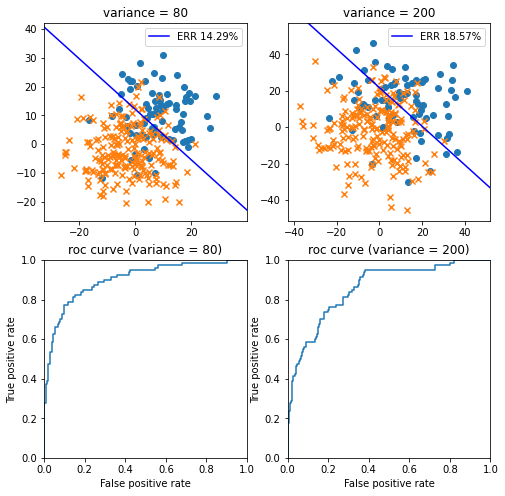

In [ ]:
# 로지스틱을 이용한 분류 시각화 및 ROC 곡선 시각화
fig,axs = plt.subplots(2,2,figsize=(8,8))
for c, variance in enumerate(variance_list):    
    training_set = prepare_dataset(initial_parameters, variance)
  
    # 로지스틱 분류 계산 및 시각화
    parameter = calc_logistic_parameter(training_set,100)
    plot_training_set(training_set,parameter, axs[0,c])
    axs[0,c].set_title("variance = %d"%(variance))
 
    # ROC 곡선 계산 및 시각화
    result = calc_roc(training_set,parameter)
    plot_roc_curve(training_set, result, axs[1,c])
    axs[1,c].set_title("roc curve (variance = %d)"%(variance)) 